In [1]:
import pint
si = pint.UnitRegistry()

In [2]:
from scipy.stats import lognorm

In [3]:
%run parcel.ipynb

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
si.setup_matplotlib()

In [5]:
rd = exp(np.linspace(
    log(10.85), 
    log(503),
    100
))[::-1] * si.nanometre

# from table 1 
assert round(rd[  1-1].magnitude, 0) == 503
assert round(rd[ 10-1].magnitude, 0) == 355
assert round(rd[ 50-1].magnitude, 1) == 75.3
assert round(rd[100-1].magnitude, 1) == 10.8

rd = rd[::-1]

In [6]:
rm = 50 * si.nanometre
sg = 1.4

nd = lognorm.pdf(rd, log(sg), 0, rm)
nd *= 1000 / np.sum(nd) / si.milligram

dr = rd[1:] - rd[0:-1]
dn_dr = nd[0:-1] / dr

# from fig. 1b
assert dn_dr.magnitude[0] > 1e-2 and dn_dr.magnitude[0] < 1e-1
assert max(dn_dr.magnitude) > 1e1 and max(dn_dr.magnitude) < 1e2
assert dn_dr.magnitude[-1] < 1e-9

C:\Users\Michael\Anaconda3\lib\site-packages\pint\quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


<IPython.core.display.Javascript object>


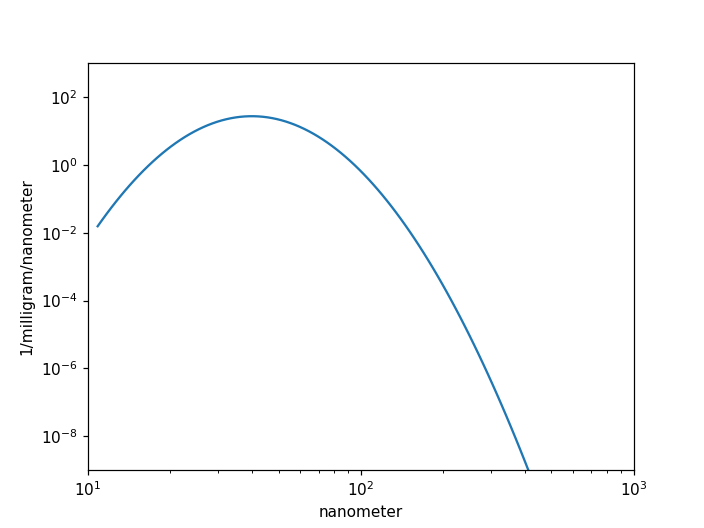

([<matplotlib.axis.YTick at 0x2486881a1d0>,
 <a list of 6 Text yticklabel objects>)

In [7]:
plt.plot(rd[0:-1], dn_dr)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e1, 1e3)
plt.ylim(1e-9, 1e3)
plt.yticks(10.**np.arange(-8, 3, step=2))  

In [8]:
integ, ix, fn = parcel(
    si = si,
    t = 40 * si.seconds,
    T0 = 300 * si.kelvin,
    q0 = 21 * si.grams / si.kilogram,
    p0 = 1000 * si.hectopascals,
    w = lambda t: 10* si.metre / si.second,
    nd = nd, 
    rd = rd, 
    kp = 1.28,
    dt_max = 0.05 * si.second
)

In [9]:
T = integ.y[ix.T] * ix.T_unit
p = integ.y[ix.p] * ix.p_unit
q = integ.y[ix.q] * ix.q_unit
r = fn.r(integ.y[ix.x] * ix.x_unit)
t = integ.t * ix.t_unit

<IPython.core.display.Javascript object>


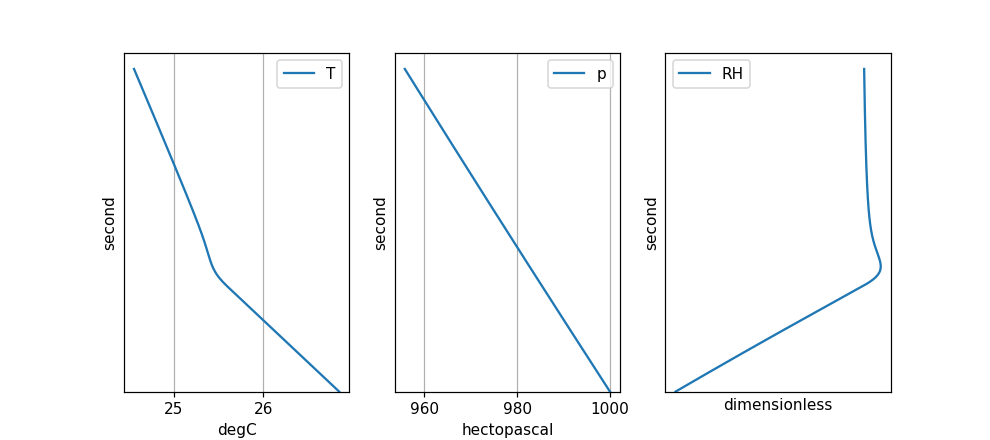

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

plt.xticks([])
plt.yticks([])
ax1.set_ylim([0, 42])

ax1.plot(T, t, label="T")
ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.celsius)

ax2.plot(p, t, label="p")
ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.hectopascals)

ax3.plot(phys.RH(T, p, q), t, label="RH")
ax3.grid()
ax3.legend()



<IPython.core.display.Javascript object>


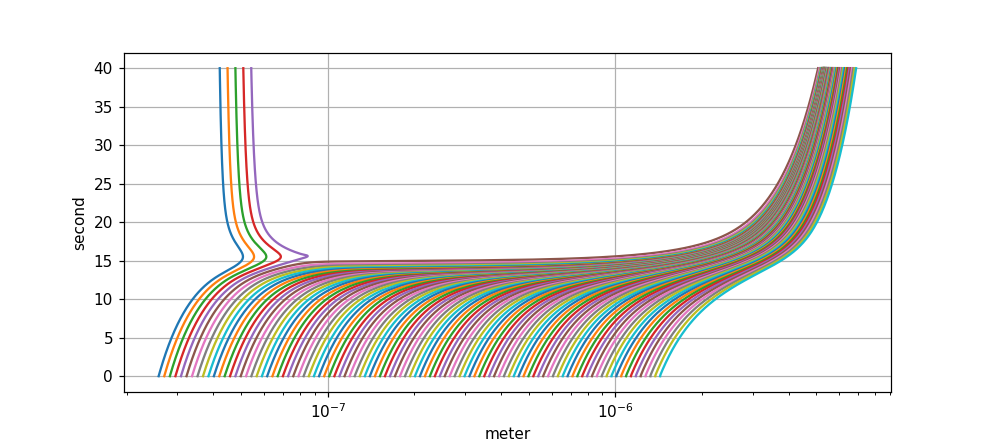

In [11]:
plt.figure(figsize=(9,4))
for i in range(ix.x.stop - ix.x.start):
    plt.plot(r[i], t, label="r_"+str(i))

plt.xscale('log')
# plt.yscale('log')
plt.grid()
# plt.legend()

plt.show()

<IPython.core.display.Javascript object>


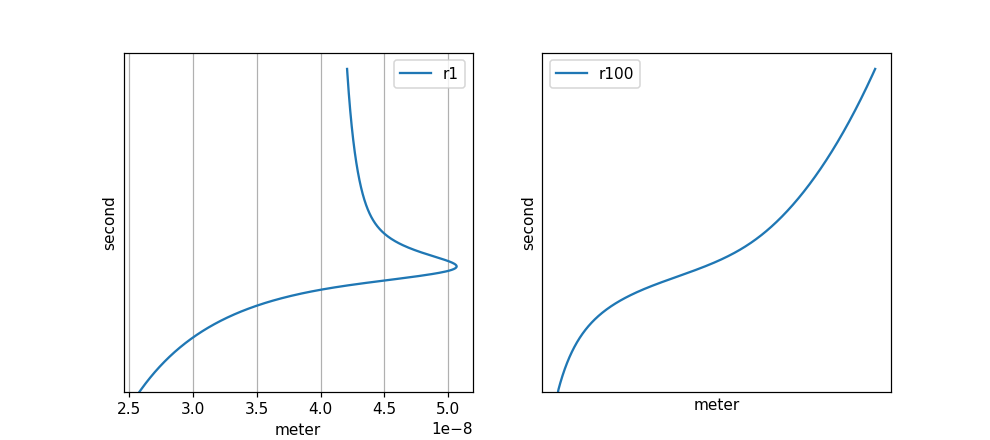

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,4))

plt.xticks([])
plt.yticks([])
ax1.set_ylim([0, 42])

ax1.plot(r[0], t, label="r1")
ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.metre)

ax2.plot(r[99], t, label="r100")
ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.metre)